In [1]:
import os
from typing import TypedDict, List, Annotated

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.graph import StateGraph, END
from langchain_groq.chat_models import ChatGroq

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

# from langchain_core.pydantic_v1 import BaseModel
from pydantic import BaseModel

from IPython.display import Image, display

from tavily import TavilyClient

# Loading the API key from .env
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [2]:
class AgentState(TypedDict):
    task: str # The name of the task, provided by the user.
    max_revisions: int # The maximum number of revisions, provided by the user.
    revision_number: int 
    plan: str
    draft: str
    critique: str
    docs: List[str]


In [3]:
llm = ChatGroq(model="llama-3.1-70b-versatile",
               stop_sequences="[end]",
               temperature=0.)

In [4]:
PLAN_PROMT = """
    You are a skilled writer. Create a comprehensive outline for a high-level essay.
    Write a detailed outline on the topic provided by the user.
    Provide a structured essay outline, accompanied by relevant notes and section guidelines.
"""
SEARCH_QUERIES_PROMPT = """
     You are a researcher charged with providing information that can be used when writing the following essay.
     Generate a list of targeted search queries to gather relevant information for the essay.
     Generate a maximumn of 3 search queries.
"""
WRITER_PROMPT = """
     Write a high-quality 5-paragraph essay based on the provided information.
     Create an essay that meets the user's request and adheres to the initial outline.
     Essay should adhere to the initial outline including headings of intial outline.
     If the user provides feedback, revise your previous essay and submit an improved version.
     Use all the information provided below as necessary to complete the essay:

     ----------------------------

     {content}
"""
REFLECTION_PROMPT = """
     You are to evaluate the user's essay submission and provide a detailed critique.
     Generate recommendations for the user's submission, including suggestions for improvement in length, depth, and style.
     Provide specific feedback to the user on how to enhance their essay, addressing areas such as organization, tone, and clarity etc.
"""
CRITIQUE_PROMPT = """
     You are a researcher charged to identify and provide information for potential revisions (as outlined below).
     Generate a list of up to three relevant search queries to gather necessary information.
"""


In [5]:
class Queries(BaseModel):
    queries: List[str]

In [6]:
tavily = TavilyClient()

In [ ]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMT),
        HumanMessage(content=state['task'])
    ]
    response = llm.invoke(messages)
    return {'plan': response.content}

In [ ]:
def research_node(state: AgentState):
    queries = llm.with_structured_output(Queries).invoke([
        SystemMessage(content=SEARCH_QUERIES_PROMPT),
        HumanMessage(content=state['task'])
    ])
    docs = state.get('docs', [])

    for query in queries.queries:
        response = tavily.search(query=query, max_results=2)
        for r in response['results']:
            docs.append(r['content'])
    # print(f"research_node: {docs}")
    return {'docs': docs}


In [ ]:
def writer_node(state: AgentState):
    content = "\n\n".join(state.get('docs', []))
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        HumanMessage(content=(
            f"{state['task']}\n\nHere is the plan: {state['plan']}"
        ))
    ]
    response = llm.invoke(messages)
    return {
        'draft': response.content,
        'revision_number': state.get('revision_number', 1) + 1
    }

In [ ]:
def reflection_node(state: AgentState):
    
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = llm.invoke(messages)
    return {'critique': response.content}

In [ ]:
def critique_research_node(state: AgentState):
    queries = llm.with_structured_output(Queries).invoke([
        SystemMessage(content=CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    docs = state.get('docs', [])

    for query in queries.queries:
        response = tavily.search(query=query, max_results=2)
        for r in response['results']:
            docs.append(r['content'])
    return {'docs': docs}
    

In [12]:
def should_continue(state: AgentState):
    if state['revision_number'] > state['max_revisions']:
        return END
    return 'reflector'

In [13]:
graph_builder = StateGraph(AgentState)

# Adding nodes to the graph
graph_builder.add_node('planner', plan_node)
graph_builder.add_node('writer', writer_node)
graph_builder.add_node('reflector', reflection_node)
graph_builder.add_node('researcher', research_node)
graph_builder.add_node('critique_researcher', critique_research_node)

# Setting the entry point of the state graph
graph_builder.set_entry_point('planner')

# Adding the conditional edge
graph_builder.add_conditional_edges(
    'writer', 
    should_continue, 
    {END: END, 'reflector': 'reflector'}
)

graph_builder.add_edge('planner', 'researcher')
graph_builder.add_edge('researcher', 'writer')

graph_builder.add_edge('reflector', 'critique_researcher')
graph_builder.add_edge('critique_researcher', 'writer')


In [14]:
memory = SqliteSaver.from_conn_string(':memory:')
graph = graph_builder.compile(checkpointer=MemorySaver())

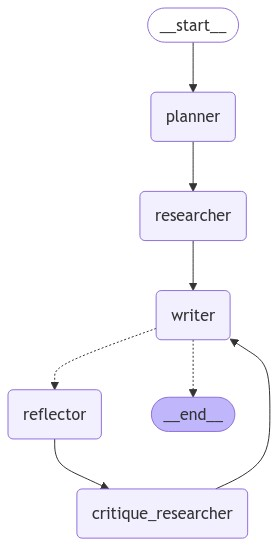

In [15]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
thread = {'configurable': {'thread_id': '1'}}
task = 'Large Language Models and LangChain'

prompt = {
    'task': task,
    'max_revisions': 2,
    'revision_number': 1,
}

events = graph.stream(prompt, thread)
# print(events)
for e in events:
    print(e)
    print('-' * 100)

{'planner': {'plan': '**Essay Title:** "Revolutionizing Human-Computer Interaction: The Synergy of Large Language Models and LangChain"\n\n**I. Introduction**\n\n* Hook: The rapid advancement of artificial intelligence has led to the development of large language models and LangChain, transforming the way humans interact with computers.\n* Background: Brief overview of large language models and LangChain, highlighting their individual capabilities and limitations.\n* Thesis statement: The integration of large language models and LangChain has the potential to revolutionize human-computer interaction, enabling more efficient, intuitive, and personalized experiences.\n\n**II. Large Language Models: Capabilities and Limitations**\n\n* Definition: Explanation of large language models, including their architecture, training data, and applications.\n* Capabilities:\n\t+ Natural language processing (NLP) and understanding\n\t+ Text generation and summarization\n\t+ Conversational AI and dialo

In [17]:
print(e['writer']['draft'])

Revolutionizing Human-Computer Interaction: The Synergy of Large Language Models and LangChain

The rapid advancement of artificial intelligence has led to the development of large language models and LangChain, transforming the way humans interact with computers. Large language models have demonstrated remarkable capabilities in natural language processing tasks, while LangChain provides a modular and flexible framework for building conversational AI systems. The integration of these two technologies has the potential to revolutionize human-computer interaction, enabling more efficient, intuitive, and personalized experiences. This essay will explore the capabilities and limitations of large language models and LangChain, and examine the synergy between these two technologies.

Large Language Models: Capabilities and Limitations

Large language models are a type of artificial intelligence designed to process and understand human language. These models are trained on vast amounts of te